IA & Data science (LU3IN0226) -- 2019-2020
--------
*&copy; Equipe pédagogique: Gauvain Bourgne, Vincent Guigue, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander.*


# TD-TME06: préparation de données

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

BOUSBA Abdellah

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-06</tt> et rajouter à la suite de <tt>tme-06</tt> les noms des membres du binômes séparés par un tiret.

Par exemple, pour le binôme Luke Skywalker et Han Solo, le nom de fichier devient `tme-06-Skywalker-Solo`

Penser à sauvegarder fréquemment le fichier en cours de travail :
- soit en cliquant sur l'icône "disquette"
- soit par la combinaison de touches [Ctrl]-S

## Mise à jour de la librairie `iads`

### Un nouveau module dans le package
Lors du dernier TME, on a écrit la fonction `crossvalidation` qui permet d'évaluer une liste de classification par une validation croisée. On va rajouter cette fonction dans notre package `iads`.
Par contre, pour bien structurer notre package, on va placer cette fonction dans un nouveau fichier pour bien distinguer le fait que notre fonction n'est ni un classifieur, ni une fonction utilitaire.

Le fichier `evaluation.py` qui est fourni dans l'archive `tme-06.tgz` est le fichier qui va servir à placer des fonctions d'évaluation de classifieurs comme `crossvalidation`.

Commencer par placer ce fichier `evaluation.py` dans votre répertoire de `iads/` (à côté de `Classifiers.py` et `utils.py` donc).

Copier ensuite dans ce fichier la fonction `crossvalidation` (la version finale qui prend en argument une liste de classifieurs) écrite lors du TME précédent.
Il n'y a pas besoin de la modifier.

Maintenant, pour pouvoir l'utiliser, il faut donc importer ce nouveau module que l'on vient de créer:

        # importation de evaluation
        from iadsenseignant import evaluation as ev

L'utilisation de la fonction se fait donc maintenant dans le notebook en utilisant le nom `ev.crossvalidation`.
(voir plus loin dans ce notebook un exemple d'utilisation)

### Ajout de la fonction `cree_dataframe` dans le package
Copier maintenant la fonction `cree_dataframe` dans votre module `utils.py` afin de pouvoir l'utiliser dans les notebooks à venir.

In [1]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev


### Objectifs de ce TME

L'objectif de ce TME est d'écrire des fonctions de préparation des données catégorielles afin de pouvoir utiliser les algorithmes de classification écrits depuis le début des TME.

En reprenant la fonction écrite dans les TME précédents, on commence par générer un dataset pour tester les fonctions.

Le dataset généré avec  20 lignes de  2 colonnes.


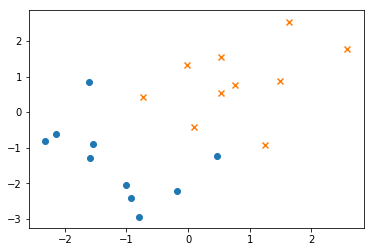

In [2]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# Exemple d'utilisation:

data_desc, data_label = ut.genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]), \
                                                   np.array([-1,-1]),np.array([[1,0],[0,1]]),\
                                                   10)

print("Le dataset généré avec ", np.shape(data_desc)[0], "lignes de ", np.shape(data_desc)[1], "colonnes.")

# Affichage :
ut.plot2DSet(data_desc,data_label)


## Expérimentations

Pour expérimenter un classifieur, il est nécessaire de posséder deux datasets distincts: 
- le dataset d'apprentissage, qui se compose donc de 2 arrays: `train_desc` et `train_labels`
- et le dataset de test, qui se compose de 2 arrays: `test_desc` et `test_labels`. 


On commence par construire le classifieur avec le dataset d'apprentisage, puis, on évalue sa performance en 2 temps :
- on calcule son **accuracy d'apprentissage** qui est l'accuracy obtenue sur le dataset d'apprentissage 
- on calcule son **accuracy de test** qui est l'accuracy obtenue sur le dataset de test

La première valeur mesure combien le classifieur a appris les données d'apprentissage, la deuxième valeur mesure sa performance en généralisation.

### Evaluation "Leave one out"

Nous avons vu 2 approches pour évaluer un algorithme d'apprentissage:
- la mesure de l'accuracy sur les données d'apprentissage et sur une base de test
- la réalisation d'une validation croisée pour mesurer l'accuracy et l'écart type (pour évaluer la robustesse) mesurées sur les données utilisées pour apprendre le modèle (données d'apprentissage) et sur des données qui n'ont pas été utilisées pour mettre au point le modèle (données test)

La première approche est généralement utilisées pour comparer plusieurs modèles en regardant leur accuracy sur les mêmes données de test.
La deuxième approche est, elle, utilisée pour aussi obtenir une certaine évaluation de la robustesse du modèle appris et garantir que l'accuracy mesurée n'est pas simplement obtenue sur "un cas particulier" de données.

Cependant, il existe des cas où le dataset que l'on possède ne contient pas beaucoup d'exemples. Dans ce cas, deux possibilités:
- il y a suffisament de données dans le dataset pour réaliser une validation croisée en réduisant le nombre de paquets (ie. prendre 4 paquets au lieu de 10 par exemple);
- il y a trop peu d'exemples pour qu'une validation croisée soit réalisable, on utilise alors une autre technique d'évaluation: l'évaluation par **leave one out** (littéralement: "en mettre un de côté"). 

L'évaluation par **leave one out** procède ainsi: à partir d'un dataset $DS$ contenant $n$ exemples:
1. sortir un des exemples de $DS$ et le mettre de côté
2. apprendre le modèle sur les $n-1$ exemples non sortis de $DS$
3. tester le modèle appris sur l'exemple mis de côté: il est soit bien classé (on marque 1 pt), soit mal classé (on marque 0 pt)
4. prendre le $DS$ original est choisir un exemple différent à mettre de côté
5. reprendre en 1) 

Les étapes 4) et 5) sont faites jusqu'à ce que tous les exemples de $DS$ aient été sortis à leur tour de $DS$.
A la fin, l'accuracy de test du modèle est alors donnée par le ratio $\frac{\mbox{nombre de points marqués}}{n}$.

<i>Remarque</i>: le plus simple dans cette approche, c'est de sortir les exemples en les prenant dans l'ordre dans lequel ils sont dans le dataset.

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction `leave_one_out` qui prend en argument un algorithme d'apprentissage $C$ et un dataset $DS$ et rend l'accuracy de test de $C$ calculée sur $DS$ en utilisant l'évaluation par leave one out.

In [3]:
# ------------------------ A COMPLETER :
def leave_one_out(C, DS):
    """ Classifieur * tuple[array, array] -> float
    """
    data, label = DS
    cpt=0
    for i in range(label.size):
        test_data = data[i]
        test_label = label[i]
        train_data = np.delete(data,i,0)
        train_label = np.delete(label,i,0)
        C.train(train_data,train_label)
        if C.predict(test_data) == test_label:
            cpt+=1
            
    return cpt/label.size


In [4]:
leave_one_out(cl.ClassifierKNN(2,1),(data_desc,data_label))

0.75

## Transformation d'attributs catégoriels

Le but de cette partie est d'implémenter l'approche <i>one-hot encoding</i> pour transformer un dataset avec des attributs catégoriels en dataset numérique.

Pour mettre au point les fonctions, on travaille sur le dataset jouet vu en cours. Celui-ci est fourni dans le répertoire `data` qui se trouve dans l'archive de ce tme.

In [5]:
# Chargement des fichiers de données :

elections_df = pd.read_csv("data/elections.csv")
elections_df

,Adresse,Majeur?,Nationalite,Label
0,Paris,oui,Francais,1
1,Paris,non,Francais,-1
2,Montpellier,oui,Italien,1
3,Paris,oui,Suisse,-1
4,Strasbourg,non,Italien,-1
5,Strasbourg,non,Francais,-1
6,Strasbourg,oui,Francais,1
7,Montpellier,oui,Suisse,-1


Quelques manipulations possibles avec les dataframes: 
(pour plus de détails, regarder la documentation !)

In [6]:
# Passer du dataframe à des arrays:
elections_desc = np.array(elections_df[['Adresse', 'Majeur?','Nationalite']])
elections_label = np.array(elections_df['Label'])

In [7]:
# obtenir les noms des colonnes :
elections_df.columns

Index(['Adresse', 'Majeur?', 'Nationalite', 'Label'], dtype='object')

In [8]:
# array avec les valeurs uniques d'une colonne donnée :
elections_df['Adresse'].unique()

array(['Paris', 'Montpellier', 'Strasbourg'], dtype=object)

In [9]:
# Exemple :
for c in elections_df.columns:
    print('la colonne ', c, ' possède ', len(elections_df[c].unique()), ' valeurs uniques :',elections_df[c].unique())

la colonne  Adresse  possède  3  valeurs uniques : ['Paris' 'Montpellier' 'Strasbourg']
la colonne  Majeur?  possède  2  valeurs uniques : ['oui' 'non']
la colonne  Nationalite  possède  3  valeurs uniques : ['Francais' 'Italien' 'Suisse']
la colonne  Label  possède  2  valeurs uniques : [ 1 -1]


L'approche <i>one-hot encoding</i> transforme un attribut catégoriel $A$ de la façon suivante:
- chaque valeur $v$ (ie. catégorie) de l'attribut catégoriel donne naissance à un nouvel attribut numérique. Le nom de ce nouvel attribut est définit en concatenant le nom de l'attribut avec la valeur (et en insérant un _ entre les 2): $A$_$v$.
- si l'exemple possède la valeur $v$ pour $A$, alors on met $1$ comme valeur pour $A$_$v$ pour cet exemple, sinon, on met $0$.

Pour appliquer cette approche, il faut donc parcourir tous les attributs du dataframe donné (on utilise les noms des colonnes), regarder les valeurs qu'ils peuvent prendre et créer de nouvelles colonnes en conséquence, puis, parcourir chaque exemple pour donner une valeur à ces nouveaux attributs.

On peut s'inspirer de ce qui suit:

In [10]:
# On commence par recopier le dataframe original pour ne pas le modifier
dfloc = elections_df.copy()

# choix de la colonne à traiter:
colonne = 'Nationalite'
L_new = []
for v in dfloc[colonne].unique():
    nom_col = colonne + '_' + v    # nom de la nouvelle colonne à créer
    dfloc[nom_col] = 0
    dfloc.loc[dfloc[colonne] == v, nom_col] = 1
    L_new.append(nom_col)
print("colonnes créées: ",L_new)
dfloc

colonnes créées:  ['Nationalite_Francais', 'Nationalite_Italien', 'Nationalite_Suisse']


,Adresse,Majeur?,Nationalite,Label,Nationalite_Francais,Nationalite_Italien,Nationalite_Suisse
0,Paris,oui,Francais,1,1,0,0
1,Paris,non,Francais,-1,1,0,0
2,Montpellier,oui,Italien,1,0,1,0
3,Paris,oui,Suisse,-1,0,0,1
4,Strasbourg,non,Italien,-1,0,1,0
5,Strasbourg,non,Francais,-1,1,0,0
6,Strasbourg,oui,Francais,1,1,0,0
7,Montpellier,oui,Suisse,-1,0,0,1


En vous inspirant du traitement précédent, compléter la fonction suivante (regarder le résultat de l'exécution dans la boîte suivante):

In [11]:
# ------------------------ A COMPLETER
def categories_2_numeriques(DF,nom_col_label =''):
    """ DataFrame * str -> DataFrame
        nom_col_label est le nom de la colonne Label pour ne pas la transformer
        si vide, il n'y a pas de colonne label
        rend l'équivalent numérique de DF
    """
    dfloc = DF.copy()  # pour ne pas modifier DF
    L_new_cols = []    # pour mémoriser le nom des nouvelles colonnes créées
    Noms_cols = [nom for nom in dfloc.columns if nom != nom_col_label]
     
    for c in Noms_cols:
        if dfloc[c].dtypes != 'object':  # pour détecter un attribut non catégoriel
            L_new_cols.append(c)  # on garde la colonne telle quelle dans ce cas
        else:
            for v in dfloc[c].unique():
                nom_col = c + '_' + v    # nom de la nouvelle colonne à créer
                dfloc[nom_col] = 0
                dfloc.loc[dfloc[c] == v, nom_col] = 1
                L_new_cols.append(nom_col)
            
    return dfloc[L_new_cols]  # on rend que les valeurs numériques

In [12]:
categories_2_numeriques(elections_df,'Label')

,Adresse_Paris,Adresse_Montpellier,Adresse_Strasbourg,Majeur?_oui,Majeur?_non,Nationalite_Francais,Nationalite_Italien,Nationalite_Suisse
0,1,0,0,1,0,1,0,0
1,1,0,0,0,1,1,0,0
2,0,1,0,1,0,0,1,0
3,1,0,0,1,0,0,0,1
4,0,0,1,0,1,0,1,0
5,0,0,1,0,1,1,0,0
6,0,0,1,1,0,1,0,0
7,0,1,0,1,0,0,0,1


On crée maintenant une nouvelle classe qui va nous permettre d'encapsuler un dataframe catégoriel et pouvoir l'utiliser avec des classifieurs numériques.
Cette classe `AdaptateurCategoriel` a pour but:
- lors de sa création : de convertir un dataframe catégoriel en son équivalent numérique
- ensuite, de pouvoir entraîner un classifieur fourni sur les données numérisées
- de pouvoir calculer l'accuracy d'un classifieur sur les données numérisées
- de convertir un exemple catégoriel dans la représentation numérique définie par l'adaptateur
- de calculer la prédiction pour un exemple catégoriel par un classifieur numérique

Compléter la classe suivante afin qu'elle réponde à ces buts:

In [13]:
# ------------------------ A COMPLETER :
class AdaptateurCategoriel:
    """ Classe pour adapter un dataframe catégoriel par l'approche one-hot encoding
    """
    def __init__(self,DF,nom_col_label=''):
        """ Constructeur
            Arguments: 
                - DataFrame représentant le dataset avec des attributs catégoriels
                - str qui donne le nom de la colonne du label (que l'on ne doit pas convertir)
                  ou '' si pas de telle colonne. On mémorise ce nom car il permettra de toujours
                  savoir quelle est la colonne des labels.
        """
        self.DF = DF  # on garde le DF original  (rem: on pourrait le copier)
        self.nom_col_label = nom_col_label 
        
        # Conversion des colonnes catégorielles en numériques:
        self.DFcateg = categories_2_numeriques(DF, nom_col_label)
        
        # Pour faciliter les traitements, on crée 2 variables utiles:
        self.data_desc = self.DFcateg.values
        self.data_label = self.DF[nom_col_label].values
        # Dimension du dataset convertit (sera utile pour définir le classifieur)
        self.dimension = self.data_desc.shape[1]
                
    def get_dimension(self):
        """ rend la dimension du dataset dé-catégorisé 
        """
        return self.dimension
        
        
    def train(self,classifieur):
        """ Permet d'entrainer un classifieur sur les données dé-catégorisées 
        """        
        classifieur.train(self.data_desc,self.data_label)
    
    
    def accuracy(self,classifieur):
        """ Permet de calculer l'accuracy d'un classifieur sur les données
            dé-catégorisées de l'adaptateur.
            Hypothèse: le classifieur doit avoir été entrainé avant sur des données
            similaires (mêmes colonnes/valeurs)
        """
        return classifieur.accuracy(self.data_desc,self.data_label)

    def converti_categoriel(self,x):
        """ transforme un exemple donné sous la forme d'un dataframe contenant
            des attributs catégoriels en son équivalent dé-catégorisé selon le 
            DF qui a servi à créer cet adaptateur
            rend le dataframe numérisé correspondant             
        """
        out = x.copy()
        col = [nom for nom in x.columns if nom != self.nom_col_label]
        newC = [nom for nom in self.DFcateg.columns]
        for c in newC:
            out[c] = 0
        for c in col:
            name = c + '_' + x.iloc[0][c]
            out[name] = 1
        out[self.nom_col_label] = x.iloc[0][self.nom_col_label]
        newC.append(self.nom_col_label)
        return out[newC]
    
    def predict(self,x,classifieur):
        """ rend la prédiction de x avec le classifieur donné
            Avant d'être classifié, x doit être converti
        """
        x_df = self.converti_categoriel(x)
        return classifieur.predict(x_df[self.DFcateg.columns].values)
    

In [14]:
# Creation de l'adaptateur
elect_adapt = AdaptateurCategoriel(elections_df,'Label')

# Création d'un classifieur qui sera construit avec les données dé-catégorisées
un_classif = cl.ClassifierKNN(elect_adapt.get_dimension(),1)

# Apprentissage du classifieur sur les données
elect_adapt.train(un_classif)

# Mesure de son accuracy d'apprentissage 
elect_adapt.accuracy(un_classif)

100.0

In [15]:
# Creation d'un nouvel exemple pour faire de la prédiction:
new_elect_df = pd.DataFrame([['Paris', 'oui', 'Italien',1]], columns= elections_df.columns)

# Pour voir le résultat de la création:
new_elect_df

,Adresse,Majeur?,Nationalite,Label
0,Paris,oui,Italien,1


In [16]:
# On convertit l'exemple en utilisant l'adaptateur précédemment construit:
elect_adapt.converti_categoriel(new_elect_df)

,Adresse_Paris,Adresse_Montpellier,Adresse_Strasbourg,Majeur?_oui,Majeur?_non,Nationalite_Francais,Nationalite_Italien,Nationalite_Suisse,Label
0,1,0,0,1,0,0,1,0,1


In [17]:
# Classification de l'exemple convertit:
elect_adapt.predict(new_elect_df,un_classif)

1

## Expérimentations


Réaliser des expérimentations avec la base des champignons `mushrooms-1000.csv` qui est fournie dans le répertoire `data`. Ce dataset est une version réduite du dataset original qui comporte plus de 8000 champignons.


In [18]:
# Chargement des fichiers de données :

mushrooms_df = pd.read_csv("data/mushrooms-1000.csv")
mushrooms_df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


**Remarque:** dans ce dataset, le label correspond à la colonne `class`, il y a 2 classes: `e` pour *edible* (comestible) et `p` pour *poisonous* (non comestible). Vous penserez à transformer cette colonne en une colonne dont les labels sont +1 (pour comestible) et -1 (pour non comestible).

In [19]:
# ------------------------ A COMPLETER :
mushrooms_df['Label'] = 0

mushrooms_df.loc[mushrooms_df['class'] == 'e', 'Label'] = 1
mushrooms_df.loc[mushrooms_df['class'] == 'p', 'Label'] = -1

del mushrooms_df['class']        

In [20]:
# Après modification: création d'une colonne Label et suppression de la colonne class:
mushrooms_df

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,Label
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,-1
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,1
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,1
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,-1
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,1
5,x,y,y,t,a,f,c,b,n,e,...,w,w,p,w,o,p,k,n,g,1
6,b,s,w,t,a,f,c,b,g,e,...,w,w,p,w,o,p,k,n,m,1
7,b,y,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,s,m,1
8,x,y,w,t,p,f,c,n,p,e,...,w,w,p,w,o,p,k,v,g,-1
9,b,s,y,t,a,f,c,b,g,e,...,w,w,p,w,o,p,k,s,m,1


In [21]:
mushrooms_df.shape

(1000, 23)

In [29]:
# Exemple d'utilisation souhaitée:


# Creation de l'adaptateur
mushrooms_adapt = AdaptateurCategoriel(mushrooms_df,'Label')

# Création d'un classifieur qui sera construit avec les données dé-catégorisées
un_classif = cl.ClassifierKNN(mushrooms_adapt.get_dimension(),5)

# Apprentissage du classifieur sur les données
mushrooms_adapt.train(un_classif)

# Mesure de son accuracy d'apprentissage 
mushrooms_adapt.accuracy(un_classif)

100.0

In [31]:

ok = (mushrooms_adapt.data_desc, mushrooms_adapt.data_label)
mushrooms_adapt.data_desc.shape

(1000, 65)

In [30]:
ev.crossvalidation(un_classif,ok)

((100.0, 0.0), (100.0, 0.0))

### validation croisée et comparaison d'algorithmes

Rajouter une méthode `cross_validation()` dans la classe `AdaptateurCategoriel` qui prend en argument un classifieur et réalise une validation croisée sur les données que l'adaptateur contient. 
Réaliser ensuite des comparaisons des algorithmes que vous avez implémentés sur la base de mushrooms.

Trouver la base mushrooms complète sur internet et réaliser des expérimentations avec.

In [26]:
mushrooms_df2 = pd.read_csv("data/mushrooms.csv")

mushrooms_df2

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


In [27]:
mushrooms_df2['Label'] = 0

mushrooms_df2.loc[mushrooms_df2['class'] == 'e', 'Label'] = 1
mushrooms_df2.loc[mushrooms_df2['class'] == 'p', 'Label'] = -1

del mushrooms_df2['class']  

In [28]:
# Exemple d'utilisation souhaitée:

# Creation de l'adaptateur
mushrooms_adapt = AdaptateurCategoriel(mushrooms_df2,'Label')

# Création d'un classifieur qui sera construit avec les données dé-catégorisées
un_classif = cl.ClassifierKNN(mushrooms_adapt.get_dimension(),3)

# Apprentissage du classifieur sur les données
mushrooms_adapt.train(un_classif)

# Mesure de son accuracy d'apprentissage 
mushrooms_adapt.accuracy(un_classif)

100.0